# Image Classification Project (Athletes)

In [169]:
import os
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Preprocessing

### Preprocessing (1) : Detecting face and eyes

When analyzing an image, the most common method of identifying a person is through their face. Images may contain multiple faces, or the face might be obstructed, making it unclear. The initial step in our pre-processing pipeline is to detect faces in the image. After identifying a face, we will proceed to detect the eyes. If both eyes are detected, we will keep the image; if not, we will discard it.

To accomplish face and eye detection, we'll use the Haar Cascade classifier from OpenCV. For more details on how to implement this, you can check out this tutorial: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html?highlight=haar

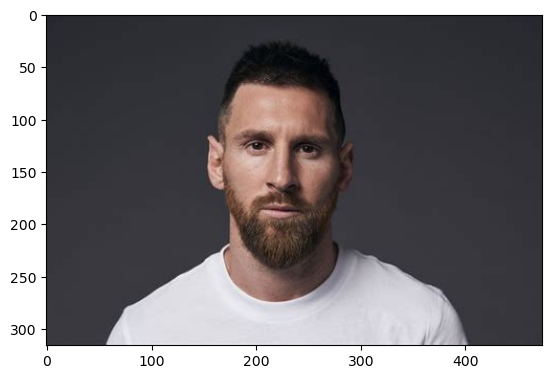

In [170]:
img = cv2.imread('./test_images/messi2.jpg')
img.shape


img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert it to RGB format

plt.imshow(img_rgb)  # Display the image
plt.show()

In [171]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray.shape

gray

array([[40, 40, 40, ..., 40, 41, 41],
       [40, 40, 40, ..., 40, 40, 40],
       [40, 40, 40, ..., 40, 40, 40],
       ...,
       [66, 57, 60, ..., 54, 45, 52],
       [74, 60, 59, ..., 54, 62, 78],
       [82, 63, 58, ..., 54, 51, 75]], dtype=uint8)

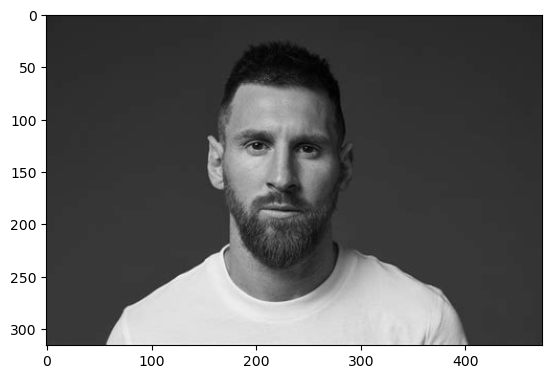

In [172]:
plt.imshow(gray, cmap= 'gray')  # Display the image
plt.show()

__Using OpenCV's haarcascades__

In [173]:
import cv2

# Use OpenCV's built-in haarcascades directory
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# Read the image
img = cv2.imread('./test_images/messi2.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
print(faces)


[[153  71 143 143]]


In [174]:
(x,y,w,h) = faces[0]
x,y,w,h

(153, 71, 143, 143)

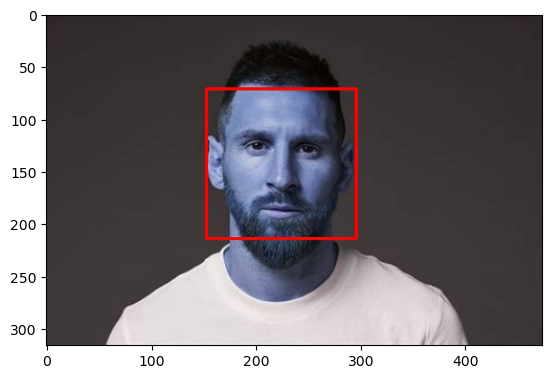

In [175]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)
plt.show()


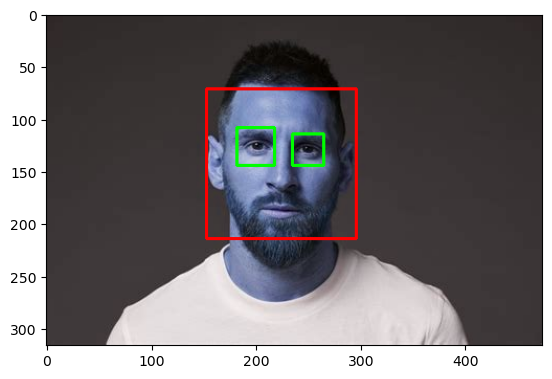

In [176]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img, (x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y: y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color, (ex,ey), (ex+ew, ey+eh), (0, 255,0), 2)

plt.figure()
plt.imshow(face_img, cmap = 'gray')
plt.show()
           
    

## Preprocessing (2): Cropping the facial region of the image

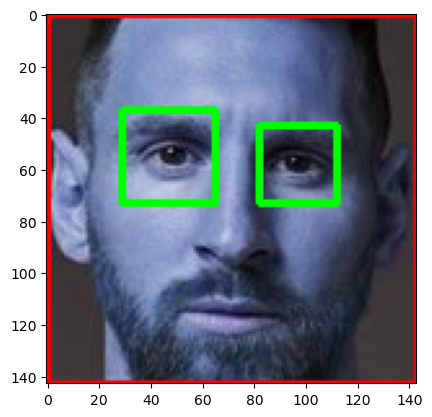

In [177]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')
plt.show()

In [178]:
cropped_img = np.array(roi_color)
cropped_img.shape

(143, 143, 3)

### Preprocessing (3): Using wavelet transform to train the model

You can see the edges of the transformed image and then get cluse on various other facial features like eyes, nose, lips, etc. 

In [179]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    if img is None:
        raise ValueError("❌ Error: Input image is None. Check the image path or format.")

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Normalize to [0,1] range
    imArray = np.float32(gray) / 255.0

    # Compute wavelet coefficients
    coeffs = pywt.wavedec2(imArray, mode, level=level)

    # Set approximation coefficients (LL) to zero
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0

    # Reconstruct the image
    imArray_H = pywt.waverec2(coeffs_H, mode)

    # Rescale to [0,255] and convert to uint8
    imArray_H = np.clip(imArray_H * 255, 0, 255).astype(np.uint8)

    # Ensure the output shape matches the input
    imArray_H = cv2.resize(imArray_H, (img.shape[1], img.shape[0]))

    return imArray_H


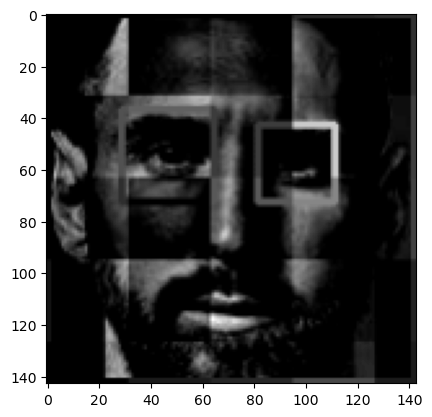

In [180]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')
plt.show()

__Above, you can observe a wavelet-transformed image, which highlights key facial features like the eyes, nose, and lips. This transformed image, combined with the raw pixel data, provides valuable information that can be fed into our classifier for more accurate detection and analysis.__

### Preprocessing (3): Load the input image, detect the face, and check if at least two eyes are detected. If both conditions are met, the function will return the cropped face region.

Let's create a Python function that accepts an input image and returns a cropped version of the face, but only if a face is detected and at least two eyes are identified.

In [181]:
import cv2
import os

# Initialize face and eye cascades
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

def get_cropped_image_if_2_eyes(image_path):
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image at {image_path}")
        return None
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    for (x, y, w, h) in faces:
        # Region of interest (ROI) for face
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        
        # Detect eyes in the face region
        eyes = eye_cascade.detectMultiScale(roi_gray)
        
        # If at least two eyes are detected, return the cropped face
        if len(eyes) >= 2:
            return roi_color

# Directory containing images
img_dir = "./model/datasets"

# Iterate through the directory and process each image file
for entry in os.scandir(img_dir):
    if entry.is_file():  # Ensure it's a file, not a directory
        print(f"Processing file: {entry.path}")
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            # Process the cropped image, save, etc.
            print(f"Processed image: {entry.path}")

    
    


        

Processing file: ./model/datasets/.DS_Store
Error: Unable to load image at ./model/datasets/.DS_Store


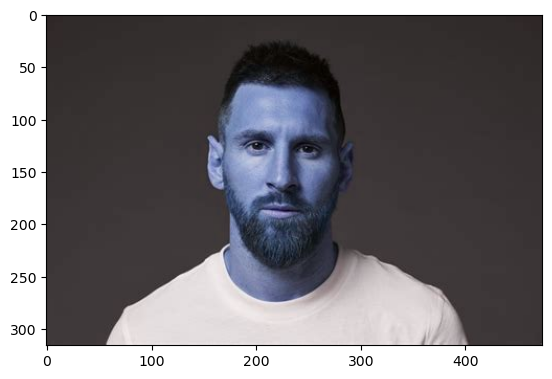

In [182]:
original_image = cv2.imread('./test_images/messi2.jpg')
plt.imshow(original_image)
plt.show()

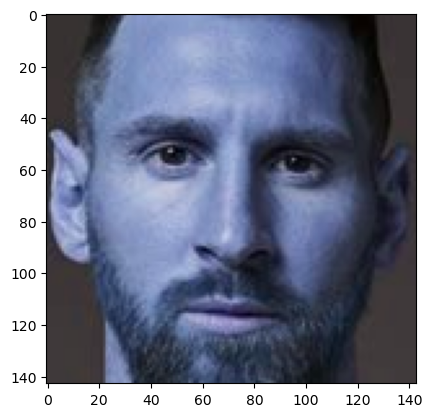

In [183]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/messi2.jpg')
plt.imshow(cropped_image)
plt.show()

__Above image, the eyes are clearly visible__

__Now, the following image is not very clear as it does not have two eyes clearly visible__

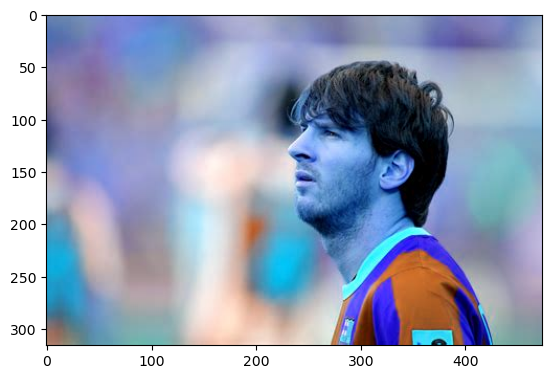

In [184]:
org_image_obstructed = cv2.imread('./test_images/messi3.jpg')
plt.imshow(org_image_obstructed)
plt.show()

In [185]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./test_images/messi3.jpg')
cropped_image_no_2_eyes

__the get_cropped_no_2_eyes is none and will be ignored to train the model__

In [186]:
path_to_data = "./model/datasets/"
path_to_cr_data = "./model/datasets/cropped/"

In [187]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [188]:
img_dirs

['./model/datasets/maria_sharapova',
 './model/datasets/virat_kohli',
 './model/datasets/lionel_messi',
 './model/datasets/serena_williams',
 './model/datasets/roger_federer']

__Go through all images in dataset folder and create cropped images for them. There will be a cropped folder inside dataset folder after one runs this code__

In [227]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [228]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1


Generating cropped images in folder:  ./model/datasets/cropped/maria_sharapova
Error: Unable to load image at ./model/datasets/maria_sharapova/yH5BAEKAAEALAAAAAABAAEAAAICTAEAOw==.gif
Error: Unable to load image at ./model/datasets/maria_sharapova/Google.svg
Generating cropped images in folder:  ./model/datasets/cropped/virat_kohli
Error: Unable to load image at ./model/datasets/virat_kohli/www.ipl.com.ico
Error: Unable to load image at ./model/datasets/virat_kohli/sports.ndtv.com.ico
Error: Unable to load image at ./model/datasets/virat_kohli/www.msn.com.ico
Error: Unable to load image at ./model/datasets/virat_kohli/facebook28px.svg
Error: Unable to load image at ./model/datasets/virat_kohli/www.indiatoday.in.ico
Error: Unable to load image at ./model/datasets/virat_kohli/svg+xml;base64,PHN2ZyBmaWxsPSJub25lIiB2aWV3Qm94PSIwIDAgOTYgOTYiIHhtbG5zPSJodHRwOi8vd3d3LnczLm9yZy8yMDAwL3N2ZyI+CiAgPHBhdGggZmlsbD0iIzM5OUYyOSIgZD0iTTczLjMyNyA1MWMxLjU2IDAgMy4wMDctLjg5NyAzLjUwMi0yLjM3NkEyMi41NjYgMjIuN

libpng warning: sRGB: out of place


Generating cropped images in folder:  ./model/datasets/cropped/lionel_messi
Error: Unable to load image at ./model/datasets/lionel_messi/youtube28px.svg
Error: Unable to load image at ./model/datasets/lionel_messi/www.msn.com.ico
Error: Unable to load image at ./model/datasets/lionel_messi/facebook28px.svg
Error: Unable to load image at ./model/datasets/lionel_messi/www.sportbible.com.ico
Error: Unable to load image at ./model/datasets/lionel_messi/svg+xml;base64,PHN2ZyBmaWxsPSJub25lIiB2aWV3Qm94PSIwIDAgOTYgOTYiIHhtbG5zPSJodHRwOi8vd3d3LnczLm9yZy8yMDAwL3N2ZyI+CiAgPHBhdGggZmlsbD0iIzM5OUYyOSIgZD0iTTczLjMyNyA1MWMxLjU2IDAgMy4wMDctLjg5NyAzLjUwMi0yLjM3NkEyMi41NjYgMjIuNTY2IDAgMCAwIDc4IDQxLjQ0N.svg
Error: Unable to load image at ./model/datasets/lionel_messi/wikipedia28px_dark.svg
Error: Unable to load image at ./model/datasets/lionel_messi/globe_dark.svg
Error: Unable to load image at ./model/datasets/lionel_messi/bleacherreport.com.ico
Error: Unable to load image at ./model/datasets/lionel_mes

__Created cropped folder under dataset folder that contains cropped images__

In [229]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict


{'maria_sharapova': ['./model/datasets/cropped/maria_sharapova/maria_sharapova2.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova3.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova1.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova4.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova5.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova7.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova6.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova17.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova16.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova28.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova14.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova15.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova29.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova11.png',
  './model/datasets/cropped/maria_sh

In [230]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'maria_sharapova': ['./model/datasets/cropped/maria_sharapova/maria_sharapova2.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova3.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova1.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova4.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova5.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova7.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova6.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova17.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova16.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova28.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova14.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova15.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova29.png',
  './model/datasets/cropped/maria_sharapova/maria_sharapova11.png',
  './model/datasets/cropped/maria_sh

In [231]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'maria_sharapova': 0,
 'virat_kohli': 1,
 'lionel_messi': 2,
 'serena_williams': 3,
 'roger_federer': 4}

### __Images in cropped folder can be used for model training. Raw images with wavelet transformed images to train our classifier__

In [232]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])  


In [233]:
len(X[0])

4096

In [234]:
32*32*3 + 32*32

4096

In [235]:
X[0]

array([[210],
       [198],
       [194],
       ...,
       [ 11],
       [ 16],
       [  3]], dtype=uint8)

In [236]:
y[0]

0

In [237]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(160, 4096)

## Data Cleaning Done. Model Training begins

__We will use SVM with rbf kernel to train model__

In [238]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [239]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.825

In [240]:
len(X_test)

40

In [241]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       1.00      0.83      0.91        12
           2       0.80      0.89      0.84         9
           3       0.67      1.00      0.80        10
           4       1.00      0.33      0.50         3

    accuracy                           0.82        40
   macro avg       0.89      0.74      0.77        40
weighted avg       0.87      0.82      0.82        40



## Let's use GridSearch to try out different models with different parameters. Goal is to come up with best model with best fine tuned parameters

In [242]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [243]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [256]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in ve

,model,best_score,best_params
0,svm,0.816667,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.658333,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.791667,{'logisticregression__C': 1}


In [257]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, multi_class='auto',
                                     solver='liblinear'))])}

In [258]:
best_estimators['svm'].score(X_test,y_test)

0.8

In [259]:
best_estimators['random_forest'].score(X_test,y_test)

0.575

In [260]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8

In [261]:
best_clf = best_estimators['svm']

In [262]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 4,  0,  0,  1,  1],
       [ 0, 11,  1,  0,  0],
       [ 0,  0,  7,  1,  1],
       [ 1,  0,  0,  9,  0],
       [ 0,  0,  1,  1,  1]])

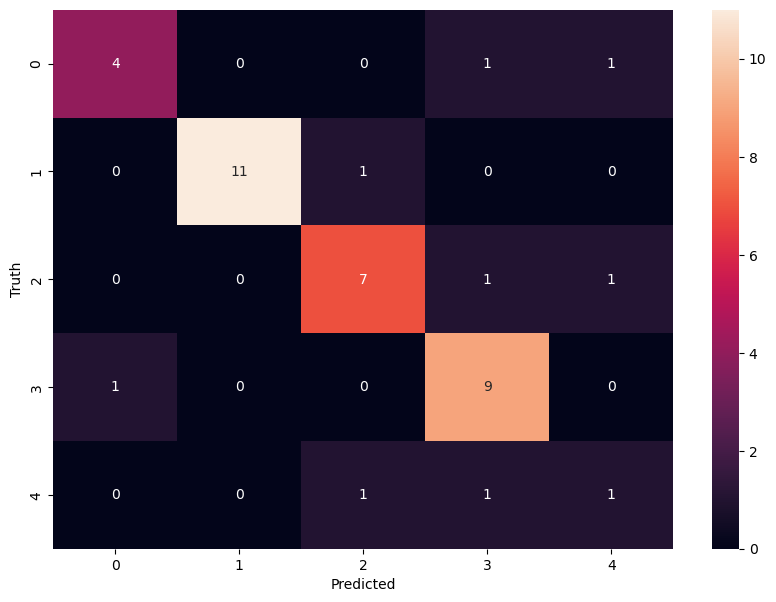

In [263]:
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

plt.show()  # This will display the plot


In [264]:
class_dict


{'maria_sharapova': 0,
 'virat_kohli': 1,
 'lionel_messi': 2,
 'serena_williams': 3,
 'roger_federer': 4}

In [265]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [266]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))